In [1]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
%matplotlib inline

import time

# Dimension reduction and clustering libraries
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, accuracy_score, precision_score, recall_score
from tensorflow.keras import Model, Input, layers, losses, optimizers, datasets
from bokeh.plotting import figure, show, output_notebook, gridplot,ColumnDataSource
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf


import dynamo as dyn
import anndata as ad

In [2]:
import glob
import pandas as pd

files = glob.glob("../data/2014/CMLS_*.csv")
dfs = [pd.read_csv(f, header=None, sep=",") for f in files]

df = pd.concat(dfs,ignore_index=True)
df.columns = ["Station_id","IODateTime","DataType","Value"]

# df = df[(df.Station_id != "CM-LS-241") & (df.Station_id != "CM-LS-125") & (df.Station_id != "CM-LS-177") & (df.Station_id != "CM-LS-178")]

In [3]:
# df = df.drop(columns=['SignalQuality'])
df = df[df['DataType'] != 'SignalQuality']
df

,Station_id,IODateTime,DataType,Value
0,CM-LS-114,2014-01-01 00:00:00,Temperature,15.3
1,CM-LS-114,2014-01-01 00:05:00,Temperature,15.4
2,CM-LS-114,2014-01-01 00:10:00,Temperature,15.4
3,CM-LS-114,2014-01-01 00:15:00,Temperature,15.4
4,CM-LS-114,2014-01-01 00:20:00,Temperature,15.1
...,...,...,...,...
19584656,CM-LS-241,2019-12-27 13:40:00,BatteryVoltage,13.5
19584657,CM-LS-241,2019-12-27 13:45:00,BatteryVoltage,13.5
19584658,CM-LS-241,2019-12-27 13:50:00,BatteryVoltage,13.5
19584659,CM-LS-241,2019-12-27 13:55:00,BatteryVoltage,13.5


In [4]:
df_cleansing = df.pivot(index=['IODateTime', 'Station_id'], columns='DataType', values='Value').reset_index()
df_cleansing = df_cleansing.dropna()
df_cleansing

DataType,IODateTime,Station_id,BatteryVoltage,Humidity,Rain,Temperature
0,2014-01-01 00:00:00,CM-LS-002,12.8,87.2,0.2,15.5
1,2014-01-01 00:00:00,CM-LS-010,13.0,74.4,0.2,14.2
2,2014-01-01 00:00:00,CM-LS-029,10.6,0.1,0.4,14.9
3,2014-01-01 00:00:00,CM-LS-032,13.1,51.6,0.0,15.2
4,2014-01-01 00:00:00,CM-LS-037,12.8,93.8,0.0,15.8
...,...,...,...,...,...,...
3917100,2019-12-27 13:55:00,CM-LS-125,13.5,56.4,0.0,30.1
3917101,2019-12-27 13:55:00,CM-LS-177,13.5,55.6,0.0,28.8
3917102,2019-12-27 13:55:00,CM-LS-241,13.5,59.7,0.0,27.5
3917103,2019-12-27 14:00:00,CM-LS-018,13.5,47.6,0.0,28.3


In [5]:
df_cleansing.columns = ['IODateTime', 'Station_id', 'Value_BatteryVoltage', 'Value_Humidity', 'Value_Rain', 'Value_Temperature']
df_cleansing

,IODateTime,Station_id,Value_BatteryVoltage,Value_Humidity,Value_Rain,Value_Temperature
0,2014-01-01 00:00:00,CM-LS-002,12.8,87.2,0.2,15.5
1,2014-01-01 00:00:00,CM-LS-010,13.0,74.4,0.2,14.2
2,2014-01-01 00:00:00,CM-LS-029,10.6,0.1,0.4,14.9
3,2014-01-01 00:00:00,CM-LS-032,13.1,51.6,0.0,15.2
4,2014-01-01 00:00:00,CM-LS-037,12.8,93.8,0.0,15.8
...,...,...,...,...,...,...
3917100,2019-12-27 13:55:00,CM-LS-125,13.5,56.4,0.0,30.1
3917101,2019-12-27 13:55:00,CM-LS-177,13.5,55.6,0.0,28.8
3917102,2019-12-27 13:55:00,CM-LS-241,13.5,59.7,0.0,27.5
3917103,2019-12-27 14:00:00,CM-LS-018,13.5,47.6,0.0,28.3


In [7]:
df_cleansing[df_cleansing.Value_Humidity < 1].shape

(666608, 6)

In [8]:
df_c = pd.wide_to_long(df_cleansing, stubnames='Value', i=['IODateTime', 'Station_id'], j='DataType', sep='_', suffix=r'\w+').reset_index()

In [9]:
df = df_c.sort_values(by=['DataType','Station_id', 'IODateTime']).reset_index()

In [10]:
df['IODateTime'] = pd.to_datetime(df['IODateTime'],format='%Y-%m-%d %H:%M:%S')
df["time"] = df.IODateTime.dt.strftime('%H:%M')
df["d"] = df.IODateTime.dt.date
df["doy"] = df.IODateTime.dt.dayofyear
df["year"] = df.IODateTime.dt.year

In [11]:
df

,index,IODateTime,Station_id,DataType,Value,time,d,doy,year
0,0,2014-01-01 00:00:00,CM-LS-002,BatteryVoltage,12.8,00:00,2014-01-01,1,2014
1,120,2014-01-01 00:05:00,CM-LS-002,BatteryVoltage,12.8,00:05,2014-01-01,1,2014
2,240,2014-01-01 00:10:00,CM-LS-002,BatteryVoltage,12.8,00:10,2014-01-01,1,2014
3,360,2014-01-01 00:15:00,CM-LS-002,BatteryVoltage,12.8,00:15,2014-01-01,1,2014
4,480,2014-01-01 00:20:00,CM-LS-002,BatteryVoltage,12.8,00:20,2014-01-01,1,2014
...,...,...,...,...,...,...,...,...,...
15664959,15664907,2019-12-27 13:40:00,CM-LS-241,Temperature,27.3,13:40,2019-12-27,361,2019
15664960,15664923,2019-12-27 13:45:00,CM-LS-241,Temperature,26.9,13:45,2019-12-27,361,2019
15664961,15664939,2019-12-27 13:50:00,CM-LS-241,Temperature,27.4,13:50,2019-12-27,361,2019
15664962,15664955,2019-12-27 13:55:00,CM-LS-241,Temperature,27.5,13:55,2019-12-27,361,2019


<AxesSubplot:xlabel='IODateTime'>

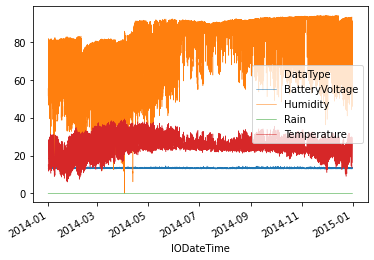

In [12]:
timeline = df[df.Station_id == "CM-LS-032"][["IODateTime", "Value", "DataType"]]
timeline = timeline.pivot(index='IODateTime', columns='DataType', values='Value')
timeline.plot(lw=0.5)

In [13]:
def errCount(_df, dt):
    if dt == "Temperature":
        return np.where((_df < -10) | (_df > 60), 1, 0).sum(axis=1)
    elif dt == "Humidity":
        return np.where((_df < 1) | (_df > 100), 1, 0).sum(axis=1)
    elif dt == "Rain":
        return np.where((_df < 0) | (_df > 100), 1, 0).sum(axis=1)
    elif dt == "BatteryVoltage":
        return np.where((_df < 12) | (_df > 15), 1, 0).sum(axis=1)
    else: return [] 


In [14]:
result = pd.DataFrame()
df_X = pd.DataFrame()

dub_station = df[~df[["Station_id", "year"]].duplicated()].reset_index(drop=True)

for dtype in df.DataType.unique():
    Xdata = []
    stns = []
    for i, row in dub_station.iterrows():
        print(row.Station_id, "-", dtype)
        X = df[(df.DataType == dtype) & (df.Station_id == row.Station_id) & (df.year == row.year)].pivot(index='d', columns='time', values='Value').reset_index()
        Xdata.append(X)
        stns = stns + [row.Station_id for x in range(len(X))]

    Xdata = pd.concat(Xdata).reset_index()
    result['station'] = stns
    # result['time'] = Xdata['doy']
    result['DateTime'] = Xdata['d']
    
    Xdata = Xdata.drop(columns=['d', 'index'])  
    Xdata.columns  = dtype+"_"+Xdata.columns  

    df_X = pd.concat([df_X, Xdata], axis=1, sort=False)
    if dtype == "Rain":
        result[dtype+'_sum'] = Xdata.sum(axis=1)
        rd = Xdata.copy()
        rd.columns = rd.columns.str.split('_').str[1]
        rain1hr = rd.groupby(rd.columns.str.split(':').str[0], axis=1).sum()
        result[dtype+'_max'] = rain1hr.max(axis=1)
        result[dtype+'_min'] = rain1hr.min(axis=1)
        result[dtype+'_mean'] = rain1hr.mean(axis=1)

    else:    
        result[dtype+'_max'] = Xdata.max(axis=1)
        result[dtype+'_min'] = Xdata.min(axis=1)
        result[dtype+'_mean'] = Xdata.mean(axis=1)
    # err_count = errCount(Xdata, dtype)
    # if len(err_count) > 0:
    #     result[dtype+'_err_count'] = err_count

df_X = df_X.dropna()
result = result[result.index.isin(df_X.index.tolist())]
# result.index = result.station+"-"+result.time.astype(str) 
result['DateTime'] = pd.to_datetime(result['DateTime'],format='%Y-%m-%d')

CM-LS-002 - BatteryVoltage
CM-LS-010 - BatteryVoltage
CM-LS-018 - BatteryVoltage
CM-LS-029 - BatteryVoltage
CM-LS-032 - BatteryVoltage
CM-LS-036 - BatteryVoltage
CM-LS-037 - BatteryVoltage
CM-LS-052 - BatteryVoltage
CM-LS-052 - BatteryVoltage
CM-LS-053 - BatteryVoltage
CM-LS-084 - BatteryVoltage
CM-LS-085 - BatteryVoltage
CM-LS-089 - BatteryVoltage
CM-LS-092 - BatteryVoltage
CM-LS-093 - BatteryVoltage
CM-LS-102 - BatteryVoltage
CM-LS-104 - BatteryVoltage
CM-LS-107 - BatteryVoltage
CM-LS-112 - BatteryVoltage
CM-LS-114 - BatteryVoltage
CM-LS-117 - BatteryVoltage
CM-LS-122 - BatteryVoltage
CM-LS-124 - BatteryVoltage
CM-LS-125 - BatteryVoltage
CM-LS-130 - BatteryVoltage
CM-LS-132 - BatteryVoltage
CM-LS-136 - BatteryVoltage
CM-LS-143 - BatteryVoltage
CM-LS-152 - BatteryVoltage
CM-LS-155 - BatteryVoltage
CM-LS-158 - BatteryVoltage
CM-LS-160 - BatteryVoltage
CM-LS-170 - BatteryVoltage
CM-LS-177 - BatteryVoltage
CM-LS-178 - BatteryVoltage
CM-LS-188 - BatteryVoltage
CM-LS-220 - BatteryVoltage
C

In [15]:
df_X

time,BatteryVoltage_00:00,BatteryVoltage_00:05,BatteryVoltage_00:10,BatteryVoltage_00:15,BatteryVoltage_00:20,BatteryVoltage_00:25,BatteryVoltage_00:30,BatteryVoltage_00:35,BatteryVoltage_00:40,BatteryVoltage_00:45,...,Temperature_23:10,Temperature_23:15,Temperature_23:20,Temperature_23:25,Temperature_23:30,Temperature_23:35,Temperature_23:40,Temperature_23:45,Temperature_23:50,Temperature_23:55
0,12.8,12.8,12.8,12.8,12.8,12.8,12.8,12.8,12.8,12.8,...,15.9,16.0,15.9,15.8,15.8,15.8,15.8,15.8,15.8,15.8
1,12.8,12.8,12.8,12.8,12.8,12.8,12.8,12.8,12.8,12.8,...,17.3,17.3,17.3,17.4,17.4,17.2,17.4,17.3,17.4,17.5
2,12.9,12.8,12.8,12.9,12.8,12.8,12.8,12.8,12.8,12.8,...,18.0,18.0,18.1,18.1,18.1,18.0,18.0,18.1,18.1,18.0
3,12.8,12.8,12.8,12.8,12.8,12.8,12.8,12.8,12.8,12.8,...,19.0,18.8,18.7,18.5,18.4,18.3,18.2,18.3,18.3,18.3
4,12.8,12.8,12.8,12.8,12.8,12.8,12.8,12.8,12.8,12.8,...,19.4,19.3,19.0,18.8,18.7,18.8,18.7,18.8,18.6,18.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13654,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,...,14.8,14.8,14.7,14.6,14.7,14.6,14.5,14.4,14.4,14.4
13655,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,...,14.6,14.5,14.4,14.4,14.3,14.2,14.2,14.2,14.1,14.1
13656,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,...,15.1,15.1,15.0,14.9,14.9,14.8,14.8,14.7,14.7,14.6
13657,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,...,15.9,15.8,15.7,15.6,15.6,15.5,15.5,15.4,15.3,15.2


# check rain stuck

In [16]:
result['rain_stuck'] = 0
rain_stuck = result[result['DateTime'].dt.month.isin([5,6,7,8,9,10])]

data_set = rain_stuck[['station', 'DateTime']]
data_set['year'] = data_set.DateTime.dt.year
data_set = data_set[['station', 'year']].drop_duplicates().reset_index(drop=True)

for i, row in data_set.iterrows():
    find_rain_stuck = rain_stuck[(rain_stuck['station'] == row.station) & (rain_stuck['DateTime'].dt.year == row.year)].reset_index(drop=True)
    find_rain_stuck['rain_stuck'] = 0
    find_rain_stuck['rain_30day'] = find_rain_stuck.Rain_sum.rolling(30).sum()
    for j, inner_row in find_rain_stuck.iterrows():
        if inner_row.rain_30day == 0:
            find_rain_stuck.loc[(find_rain_stuck.index >=j-30) & (find_rain_stuck.index <= j), ['rain_stuck']] = 1
    for j, inner_row in find_rain_stuck.iterrows():
        result.loc[(result['station'] == inner_row['station']) & (result['DateTime'] == inner_row['DateTime']), ['rain_stuck']] = inner_row['rain_stuck']

c:\Users\004103\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
result[result['rain_stuck']>0]['station'].unique()

array(['CM-LS-032', 'CM-LS-052', 'CM-LS-104', 'CM-LS-117', 'CM-LS-152',
       'CM-LS-178'], dtype=object)

In [18]:
result['batt_error'] = np.where((result.BatteryVoltage_min < 12) | (result.BatteryVoltage_max > 15), 1, 0)
result['temp_error'] = np.where((result.Temperature_min < -10) | (result.Temperature_max > 60), 1, 0)
result['humid_error'] = np.where((result.Humidity_min < 1) | (result.Humidity_max > 100), 1, 0)
result['rain_error'] = np.where((result.Rain_min < 0) | (result.Rain_max > 100) | (result.rain_stuck > 0), 1, 0)

result['error_state'] = np.where(result[['batt_error','temp_error', 'humid_error', 'rain_error']].sum(axis=1) > 0, 1, 0)
result['error_label'] = np.where(result.error_state > 0, 'anomaly', 'normal')
result['error_color'] = np.where(result.error_state > 0, 'red', 'blue')

In [19]:
result

,station,DateTime,BatteryVoltage_max,BatteryVoltage_min,BatteryVoltage_mean,Humidity_max,Humidity_min,Humidity_mean,Rain_sum,Rain_max,...,Temperature_min,Temperature_mean,rain_stuck,batt_error,temp_error,humid_error,rain_error,error_state,error_label,error_color
0,CM-LS-002,2014-01-01,15.1,12.7,13.108681,88.6,46.0,77.835764,55.0,2.4,...,13.3,18.664236,0,1,0,0,0,1,anomaly,red
1,CM-LS-002,2014-01-02,15.2,12.7,13.141667,88.5,51.6,78.327778,42.0,2.4,...,13.4,19.764931,0,1,0,0,0,1,anomaly,red
2,CM-LS-002,2014-01-03,15.2,12.7,13.171528,88.5,44.8,77.736806,47.8,2.4,...,14.7,20.928125,0,1,0,0,0,1,anomaly,red
3,CM-LS-002,2014-01-04,15.3,12.7,13.183681,88.5,55.2,78.577778,38.4,2.4,...,14.7,20.946875,0,1,0,0,0,1,anomaly,red
4,CM-LS-002,2014-01-05,14.9,12.7,13.118750,89.5,58.4,81.646875,44.8,2.4,...,16.0,20.958681,0,0,0,0,0,0,normal,blue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13654,CM-LS-241,2019-12-22,13.6,12.8,13.194097,98.9,34.4,78.778819,0.2,0.2,...,12.0,19.522222,0,0,0,0,0,0,normal,blue
13655,CM-LS-241,2019-12-23,13.6,12.8,13.182292,99.0,33.4,77.961458,41.0,2.4,...,10.3,18.734375,0,0,0,0,0,0,normal,blue
13656,CM-LS-241,2019-12-24,13.6,12.8,13.181250,99.0,37.7,79.918403,0.2,0.2,...,10.3,18.633681,0,0,0,0,0,0,normal,blue
13657,CM-LS-241,2019-12-25,13.6,12.8,13.174306,99.0,40.2,80.504514,43.2,2.4,...,11.1,19.209028,0,0,0,0,0,0,normal,blue


In [20]:
result.reset_index(drop=True)

,station,DateTime,BatteryVoltage_max,BatteryVoltage_min,BatteryVoltage_mean,Humidity_max,Humidity_min,Humidity_mean,Rain_sum,Rain_max,...,Temperature_min,Temperature_mean,rain_stuck,batt_error,temp_error,humid_error,rain_error,error_state,error_label,error_color
0,CM-LS-002,2014-01-01,15.1,12.7,13.108681,88.6,46.0,77.835764,55.0,2.4,...,13.3,18.664236,0,1,0,0,0,1,anomaly,red
1,CM-LS-002,2014-01-02,15.2,12.7,13.141667,88.5,51.6,78.327778,42.0,2.4,...,13.4,19.764931,0,1,0,0,0,1,anomaly,red
2,CM-LS-002,2014-01-03,15.2,12.7,13.171528,88.5,44.8,77.736806,47.8,2.4,...,14.7,20.928125,0,1,0,0,0,1,anomaly,red
3,CM-LS-002,2014-01-04,15.3,12.7,13.183681,88.5,55.2,78.577778,38.4,2.4,...,14.7,20.946875,0,1,0,0,0,1,anomaly,red
4,CM-LS-002,2014-01-05,14.9,12.7,13.118750,89.5,58.4,81.646875,44.8,2.4,...,16.0,20.958681,0,0,0,0,0,0,normal,blue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13509,CM-LS-241,2019-12-22,13.6,12.8,13.194097,98.9,34.4,78.778819,0.2,0.2,...,12.0,19.522222,0,0,0,0,0,0,normal,blue
13510,CM-LS-241,2019-12-23,13.6,12.8,13.182292,99.0,33.4,77.961458,41.0,2.4,...,10.3,18.734375,0,0,0,0,0,0,normal,blue
13511,CM-LS-241,2019-12-24,13.6,12.8,13.181250,99.0,37.7,79.918403,0.2,0.2,...,10.3,18.633681,0,0,0,0,0,0,normal,blue
13512,CM-LS-241,2019-12-25,13.6,12.8,13.174306,99.0,40.2,80.504514,43.2,2.4,...,11.1,19.209028,0,0,0,0,0,0,normal,blue


In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
umap__X = df_X.copy()
# umap_df_X = StandardScaler().fit_transform(umap__X)
# umap_df_X

umap_df_X = MinMaxScaler().fit_transform(umap__X).astype(np.float32)
umap_df_X

array([[0.5714286 , 0.6238532 , 0.56666666, ..., 0.8689992 , 0.8682927 ,
        0.8689992 ],
       [0.5714286 , 0.6238532 , 0.56666666, ..., 0.88120425, 0.8813008 ,
        0.8828316 ],
       [0.57983196, 0.6238532 , 0.56666666, ..., 0.8877136 , 0.88699186,
        0.88689995],
       ...,
       [0.5882353 , 0.64220184, 0.5833333 , ..., 0.86004883, 0.8593496 ,
        0.85923517],
       [0.5882353 , 0.64220184, 0.5833333 , ..., 0.86574453, 0.86422765,
        0.86411715],
       [0.57983196, 0.6330275 , 0.5833333 , ..., 0.8771359 , 0.87642276,
        0.8763222 ]], dtype=float32)

In [19]:
clusterable_embedding = umap.UMAP(
    n_neighbors=800,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(umap_df_X)

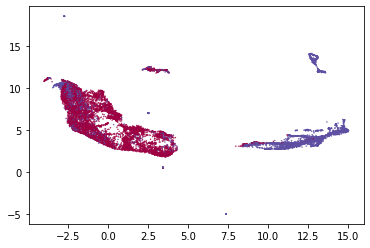

In [20]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=result.error_state, s=0.2, cmap='Spectral')

In [21]:
labels = hdbscan.HDBSCAN(
    min_samples=2,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

In [22]:
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [24]:
(
    adjusted_rand_score(result.error_state, labels),
    adjusted_mutual_info_score(result.error_state, labels)
)

(0.47906113109584786, 0.4101612384707742)

In [25]:
clustered = (labels >= 0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


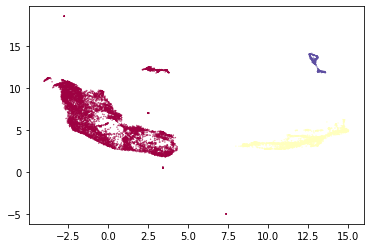

In [26]:
clustered = (labels >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [27]:
(
    adjusted_rand_score(result.error_state[clustered], labels[clustered]),
    adjusted_mutual_info_score(result.error_state[clustered], labels[clustered])
)

(0.47906113109584786, 0.4101612384707742)

In [28]:
np.sum(clustered) / result.error_state.shape[0]

1.0

In [90]:
kmeans_umap_labels = cluster.KMeans(n_clusters=2).fit_predict(clusterable_embedding)


In [105]:
indices_one = kmeans_umap_labels == 1
indices_zero = kmeans_umap_labels == 0
kmeans_umap_labels[indices_one] = 0 # replacing 1s with 0s
kmeans_umap_labels[indices_zero] = 1 # replacing 0s with 1s
print('Accuracy: {}'.format(accuracy_score(result.error_state, kmeans_umap_labels)))
print('precision: {}'.format(precision_score(result.error_state, kmeans_umap_labels)))
print('recall: {}'.format(recall_score(result.error_state, kmeans_umap_labels)))

Accuracy: 0.13941098120467663
precision: 0.17443868739205526
recall: 0.32886420226010343


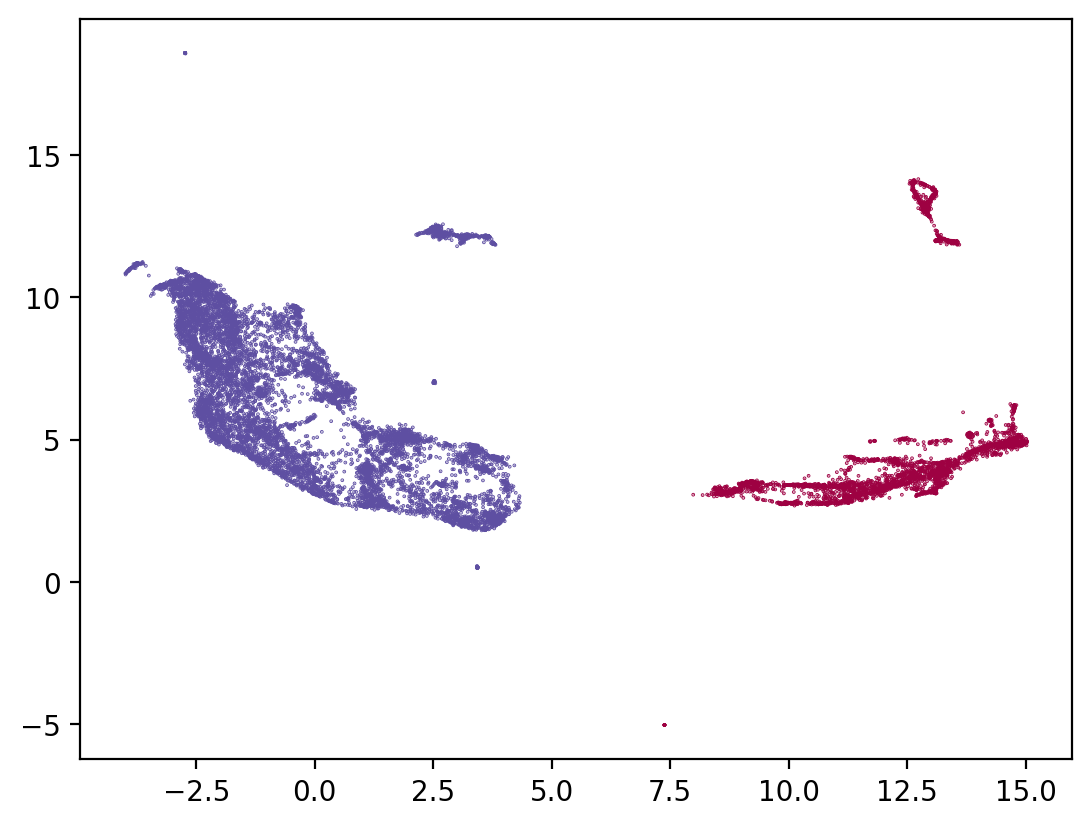

In [106]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=kmeans_umap_labels, s=0.1, cmap='Spectral');

# Dynamo


In [21]:
var = pd.DataFrame(index=df_X.columns.to_list())

In [22]:
X = df_X.copy()
X = X.to_numpy()

In [23]:
adata = ad.AnnData(X, obs=result, var=var, dtype='int32')
adata

c:\Users\004103\AppData\Local\Programs\Python\Python36\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning:

Transforming to str index.



AnnData object with n_obs × n_vars = 13514 × 1152
    obs: 'station', 'DateTime', 'BatteryVoltage_max', 'BatteryVoltage_min', 'BatteryVoltage_mean', 'Humidity_max', 'Humidity_min', 'Humidity_mean', 'Rain_sum', 'Rain_max', 'Rain_min', 'Rain_mean', 'Temperature_max', 'Temperature_min', 'Temperature_mean', 'rain_stuck', 'batt_error', 'temp_error', 'humid_error', 'rain_error', 'error_state', 'error_label', 'error_color'

In [24]:
adata.layers["spliced"] = X
adata.layers["unspliced"] = X

In [25]:
adata = dyn.pp.recipe_monocle(adata, keep_filtered_cells=False, keep_filtered_genes=False)
adata.obsm['X_pca']

c:\Users\004103\AppData\Local\Programs\Python\Python36\lib\site-packages\dynamo\preprocessing\preprocess.py:1374: UserWarning:

only 1140 genes passed basic filtering, but you requested 2000 genes for feature selection. Try lowering the gene selection stringency: {'min_expr_cells': 0, 'min_expr_avg': 0, 'max_expr_avg': inf, 'svr_gamma': None, 'winsorize': False, 'winsor_perc': (1, 99.5), 'sort_inverse': False}

c:\Users\004103\AppData\Local\Programs\Python\Python36\lib\site-packages\dynamo\preprocessing\utils.py:421: RuntimeWarning:

invalid value encountered in log1p

c:\Users\004103\AppData\Local\Programs\Python\Python36\lib\site-packages\dynamo\preprocessing\preprocess.py:1459: UserWarning:

Dynamo is not able to perform cell cycle staging for you automatically. 
Since dyn.pl.phase_diagram in dynamo by default color cells by its cell-cycle stage, 
you need to set color argument accordingly if confronting errors related to this.



array([[-1.41780639e+01, -2.11980258e+00,  8.64499588e-01, ...,
         5.33985047e-03, -8.34881627e-02, -1.77244588e-02],
       [-1.38551943e+01, -2.14238565e+00,  9.08180047e-01, ...,
         4.08323845e-03, -1.99629267e-02, -4.65190033e-03],
       [-1.35524545e+01, -2.12083084e+00,  1.16034914e+00, ...,
         9.23746345e-03, -8.01905606e-02,  1.14148005e-02],
       ...,
       [-1.51220753e+01, -1.85975611e+00,  1.91487506e+00, ...,
         7.46772587e-03, -7.27033726e-02, -3.72163652e-02],
       [-1.49636528e+01, -1.88571063e+00,  1.81922620e+00, ...,
         6.75950002e-03, -6.93169700e-02,  5.32888905e-03],
       [-1.49419113e+01, -1.94377593e+00,  1.47345539e+00, ...,
         1.46652048e-02, -8.95516983e-02, -1.93661825e-02]])

In [27]:
adata = dyn.tl.dynamics(adata, model='stochastic', est_method='negbin')

estimating gamma: 100%|██████████| 667/667 [00:49<00:00, 13.50it/s]


In [30]:

start = time.time()
dyn.tl.reduceDimension(adata, reduction_method='umap', enforce=True, n_neighbors=200)
print('Duration: {} seconds'.format(time.time() - start))

Duration: 74.5945873260498 seconds


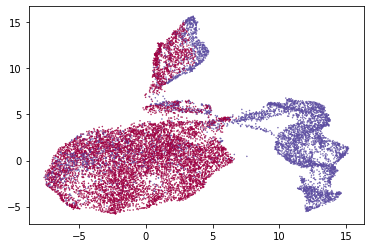

In [31]:
plt.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1],
            c=result.error_state, s=0.2, cmap='Spectral')

In [32]:
result.error_state.unique()

array([1, 0])

### HDBSCAN Eval

In [32]:
labels = hdbscan.HDBSCAN(
    min_samples=2,
    min_cluster_size=500,
).fit_predict(adata.obsm['X_umap'])

In [33]:
labels

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [34]:
(
    adjusted_rand_score(result.error_state, labels),
    adjusted_mutual_info_score(result.error_state, labels)
)

(0.067798271648761, 0.07869879589725524)

In [35]:
clustered = (labels >= 0)

In [33]:
clustered = (labels >= 0)
plt.scatter(adata.obsm['X_umap'][~clustered, 0],
            adata.obsm['X_umap'][~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(adata.obsm['X_umap'][clustered, 0],
            adata.obsm['X_umap'][clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

NameError: name 'labels' is not defined

In [37]:
(
    adjusted_rand_score(result.error_state[clustered], labels[clustered]),
    adjusted_mutual_info_score(result.error_state[clustered], labels[clustered])
)

(0.0678949340524222, 0.07875516807816925)

In [38]:
np.sum(clustered) / result.error_state.shape[0]


0.9998520053278082

In [39]:
dyn.tl.cell_velocities(adata, method='pearson', other_kernels_dict={'transform': 'sqrt'})

calculating transition matrix via pearson kernel with sqrt transform.: 100%|██████████| 13514/13514 [00:47<00:00, 283.37it/s]
projecting velocity vector to low dimensional embedding...: 100%|██████████| 13514/13514 [00:03<00:00, 4300.93it/s]


AnnData object with n_obs × n_vars = 13514 × 1152
    obs: 'station', 'DateTime', 'BatteryVoltage_max', 'BatteryVoltage_min', 'BatteryVoltage_mean', 'Humidity_max', 'Humidity_min', 'Humidity_mean', 'Rain_sum', 'Rain_max', 'Rain_min', 'Rain_mean', 'Temperature_max', 'Temperature_min', 'Temperature_mean', 'rain_stuck', 'batt_error', 'temp_error', 'humid_error', 'rain_error', 'error_state', 'error_label', 'error_color', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr'
    var: 'pass_basic_filter', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp_norm_method', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_f

<Figure size 600x400 with 0 Axes>

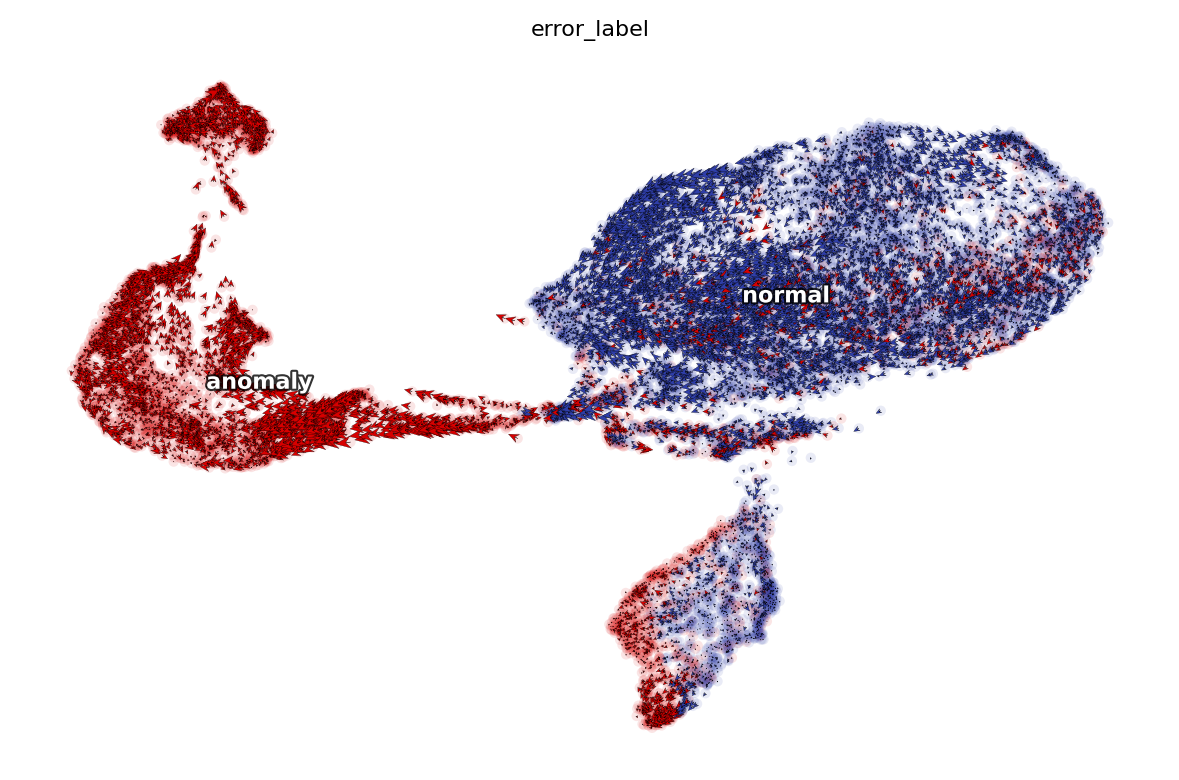

In [40]:
dyn.pl.cell_wise_vectors(adata, color=['error_label'], basis='umap', show_legend='on data', quiver_length=6, quiver_size=6, pointsize=0.1, show_arrowed_spines=False)

Sampling control points based on data velocity magnitude...
Time elapsed for 'con_K': 0.0080 s
Time elapsed for 'con_K': 0.1239 s
Time elapsed for 'con_K': 0.0227 s

iterate: 0, gamma: 0.900, energy change rate: 1.000e+00, sigma2=1.169e-01
Time elapsed for computing lhs and rhs: 0.239988 s
Time elapsed for 'lstsq_solver': 0.0307 s

iterate: 1, gamma: 0.950, energy change rate: 5.585e-01, sigma2=2.777e-02
Time elapsed for computing lhs and rhs: 0.277980 s
Time elapsed for 'lstsq_solver': 0.0250 s

iterate: 2, gamma: 0.950, energy change rate: 1.245e+00, sigma2=1.399e-01
Time elapsed for computing lhs and rhs: 0.305165 s
Time elapsed for 'lstsq_solver': 0.0259 s

iterate: 3, gamma: 0.942, energy change rate: 5.201e+00, sigma2=2.799e-02
Time elapsed for computing lhs and rhs: 0.284279 s
Time elapsed for 'lstsq_solver': 0.0883 s

iterate: 4, gamma: 0.950, energy change rate: 1.042e+00, sigma2=5.311e-01
Time elapsed for computing lhs and rhs: 0.314135 s
Time elapsed for 'lstsq_solver': 0.02

Constructing diffusion graph from reconstructed vector field: 5000it [02:32, 32.78it/s]
Calculating divergence: 100%|██████████| 13514/13514 [00:01<00:00, 9320.87it/s]


<Figure size 600x400 with 0 Axes>

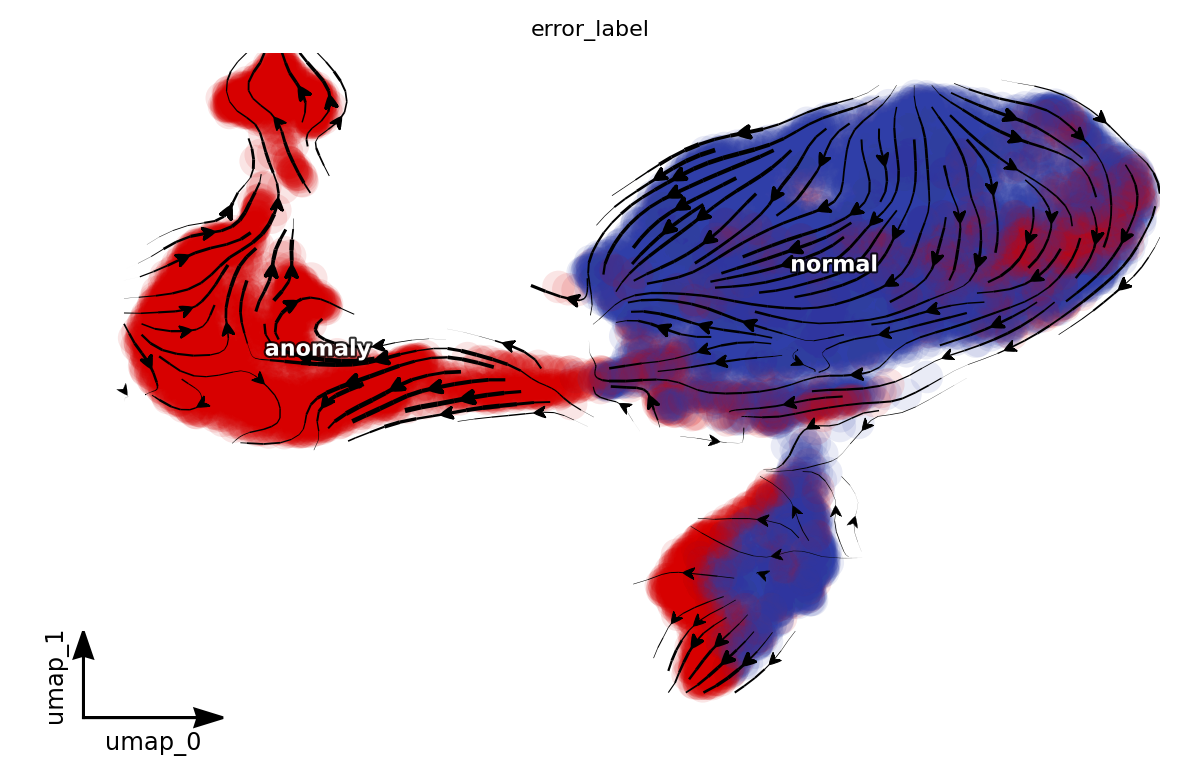

In [41]:
dyn.vf.VectorField(adata, basis='umap', pot_curl_div=True, verbose=3) # , M=1000, MaxIter=1000
dyn.pl.streamline_plot(adata, color=['error_label'], basis='umap', show_legend='on data', show_arrowed_spines=True)

### KMEAN Eval

In [34]:
kmeans_labels = cluster.KMeans(n_clusters=2).fit_predict(adata.obsm['X_umap'])

In [37]:
kmeans_labels

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
(
    adjusted_rand_score(result.error_state, kmeans_labels),
    adjusted_mutual_info_score(result.error_state, kmeans_labels)
)

(0.4988334269183716, 0.445696627864964)

In [88]:
indices_one = kmeans_labels == 1
indices_zero = kmeans_labels == 0
kmeans_labels[indices_one] = 0 # replacing 1s with 0s
kmeans_labels[indices_zero] = 1 # replacing 0s with 1s

In [39]:
kmeans_color = np.where(kmeans_labels > 0, 'red', 'blue')
kmeans_color

array(['blue', 'blue', 'blue', ..., 'blue', 'blue', 'blue'], dtype='<U4')

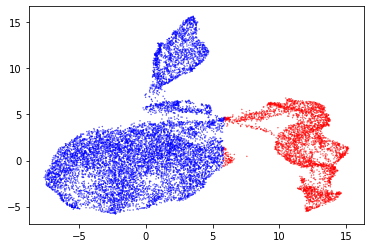

In [41]:
plt.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], c=kmeans_color, s=0.1, cmap='Spectral');


In [40]:
print('Accuracy: {}'.format(accuracy_score(result.error_state, kmeans_labels)))
print('precision: {}'.format(precision_score(result.error_state, kmeans_labels)))
print('recall: {}'.format(recall_score(result.error_state, kmeans_labels)))

Accuracy: 0.8550392185881308
precision: 0.9660398540555711
recall: 0.6518939393939394


# Autoencoder

In [51]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model
## Standardizing the data
ae_X = df_X.copy()

# ae_X = StandardScaler().fit_transform(ae_X)
# ae_X

min_max_scaler = MinMaxScaler()
ae_X = min_max_scaler.fit_transform(ae_X).astype(np.float32)
ae_X.shape

(13514, 1152)

In [52]:
inputs = Input(shape=(ae_X.shape[1],))

en1 = layers.Dense(ae_X.shape[1] // 2, activation='tanh')
en2 = layers.Dense(ae_X.shape[1] // 4, activation='tanh')
en3 = layers.Dense(ae_X.shape[1] // 6, activation='tanh')
en4 = layers.Dense(ae_X.shape[1] // 8, activation='tanh')
en5 = layers.Dense(ae_X.shape[1] // 12, activation='tanh')
en6 = layers.Dense(ae_X.shape[1] // 24, activation='tanh')
en7 = layers.Dense(ae_X.shape[1] // 48, activation='tanh')
en8 = layers.Dense(ae_X.shape[1] // 96, activation='tanh')
en9 = layers.Dense(ae_X.shape[1] // 192, activation='tanh')
en10 = layers.Dense(ae_X.shape[1] // 288, activation='tanh')
en11 = layers.Dense(ae_X.shape[1] // 576, activation='tanh')

de11 = layers.Dense(ae_X.shape[1] // 288, activation='tanh')
de10 = layers.Dense(ae_X.shape[1] // 192, activation='tanh')
de9 = layers.Dense(ae_X.shape[1] // 96, activation='tanh')
de8 = layers.Dense(ae_X.shape[1] // 48, activation='tanh')
de7 = layers.Dense(ae_X.shape[1] // 24, activation='tanh')
de6 = layers.Dense(ae_X.shape[1] // 12, activation='tanh')
de5 = layers.Dense(ae_X.shape[1] // 8, activation='tanh')
de4 = layers.Dense(ae_X.shape[1] // 6, activation='tanh')
de3 = layers.Dense(ae_X.shape[1] // 4, activation='tanh')
de2 = layers.Dense(ae_X.shape[1] // 2, activation='tanh')
de1 = layers.Dense(ae_X.shape[1], activation='tanh')

outputs = de1(de2(de3(de4(de5(de6(de7(de8(de9(de10(de11(en11(en10(en9(en8(en7(en6(en5(en4(en3(en2(en1(inputs))))))))))))))))))))))
model = Model(inputs, outputs)

In [53]:
model.compile(loss=losses.MeanSquaredError(), optimizer=optimizers.SGD(lr=0.1))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1152)]            0         
_________________________________________________________________
dense (Dense)                (None, 576)               664128    
_________________________________________________________________
dense_1 (Dense)              (None, 288)               166176    
_________________________________________________________________
dense_2 (Dense)              (None, 192)               55488     
_________________________________________________________________
dense_3 (Dense)              (None, 144)               27792     
_________________________________________________________________
dense_4 (Dense)              (None, 96)                13920     
_________________________________________________________________
dense_5 (Dense)              (None, 48)                4656  

In [54]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)

In [55]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
start = time.time()
embeding  = model.fit(ae_X, ae_X, epochs=200, callbacks=[callback])
print('Duration: {} seconds'.format(time.time() - start))

Epoch 1/200
423/423 [==============================] - 6s 10ms/step - loss: 0.1975
Epoch 2/200
423/423 [==============================] - 4s 10ms/step - loss: 0.0091
Epoch 3/200
423/423 [==============================] - 5s 12ms/step - loss: 0.0085
Epoch 4/200
423/423 [==============================] - 7s 16ms/step - loss: 0.0064
Epoch 5/200
423/423 [==============================] - 7s 17ms/step - loss: 0.0059: 0s -
Epoch 6/200
423/423 [==============================] - 6s 13ms/step - loss: 0.0056: 0s - 
Epoch 7/200
423/423 [==============================] - 5s 12ms/step - loss: 0.0055
Epoch 8/200
423/423 [==============================] - 7s 16ms/step - loss: 0.0053
Epoch 9/200
423/423 [==============================] - 7s 17ms/step - loss: 0.0050
Epoch 10/200
423/423 [==============================] - 7s 16ms/step - loss: 0.0049
Epoch 11/200
423/423 [==============================] - 7s 17ms/step - loss: 0.0047
Epoch 12/200
423/423 [==============================] - 6s 15ms/step - l

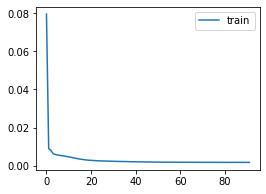

In [59]:
# plot training history
fig = plt.subplots(figsize=(4,3))
plt.plot(embeding.history['loss'], label='train')
plt.legend()
plt.show()

In [60]:
start = time.time()
XEn = en11(en10(en9(en8(en7(en6(en5(en4(en3(en2(en1(ae_X))))))))))).numpy()
print('Duration: {} seconds'.format(time.time() - start))
print(XEn.shape)

Duration: 0.25230908393859863 seconds
(13514, 2)


In [61]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(XEn)

In [62]:
labels

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [63]:
(
    adjusted_rand_score(result.error_state, labels),
    adjusted_mutual_info_score(result.error_state, labels)
)

(0.4419670923608937, 0.34869460510052724)

In [64]:
clustered = (labels >= 0)

In [65]:
(
    adjusted_rand_score(result.error_state[clustered], labels[clustered]),
    adjusted_mutual_info_score(result.error_state[clustered], labels[clustered])
)

(0.5373354204962354, 0.46497383855779334)

In [66]:
np.sum(clustered) / result.error_state.shape[0]

0.9023975136895072

In [67]:
p = figure(plot_width=450, plot_height=400,)
p.circle(XEn[:,0], XEn[:,1], color=result.error_color, fill_alpha=0.8, size=8)

show(p)

## K-Mean Eval

In [70]:
kmeans_AE_labels = cluster.KMeans(n_clusters=2).fit_predict(XEn)

In [71]:
kmeans_AE_labels

array([0, 0, 0, ..., 0, 0, 0])

In [86]:
indices_one = kmeans_AE_labels == 1
indices_zero = kmeans_AE_labels == 0
kmeans_AE_labels[indices_one] = 0 # replacing 1s with 0s
kmeans_AE_labels[indices_zero] = 1 # replacing 0s with 1s

In [72]:
print('Accuracy: {}'.format(accuracy_score(result.error_state, kmeans_AE_labels)))
print('precision: {}'.format(precision_score(result.error_state, kmeans_AE_labels)))
print('recall: {}'.format(recall_score(result.error_state, kmeans_AE_labels)))

Accuracy: 0.6030782891815895
precision: 0.4950576606260296
recall: 0.796780303030303


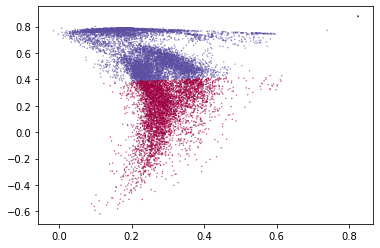

In [73]:
plt.scatter(XEn[:, 0], XEn[:, 1], c=kmeans_AE_labels, s=0.1, cmap='Spectral')

# t-SNE

In [74]:
x_tsne = df_X.copy()
x_tsne = StandardScaler().fit_transform(x_tsne)

In [76]:
start = time.time()
pca_30 = PCA(n_components=30)
pca_result_30 = pca_30.fit_transform(x_tsne)
tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=400).fit_transform(pca_result_30)
# tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=400).fit_transform(x_tsne)
print('Duration: {} seconds'.format(time.time() - start))

MemoryError: Unable to allocate 1.00 GiB for an array with shape (9931, 13514) and data type float64

In [71]:
labels = hdbscan.HDBSCAN(
    gen_min_span_tree=True,
    min_cluster_size=500
).fit_predict(tsne)

In [72]:
labels

array([ 1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [73]:
(
    adjusted_rand_score(result.error_state, labels),
    adjusted_mutual_info_score(result.error_state, labels)
)

(0.00947542380329061, 0.09463634845529789)

In [74]:
clustered = (labels >= 0)

In [75]:
(
    adjusted_rand_score(result.error_state[clustered], labels[clustered]),
    adjusted_mutual_info_score(result.error_state[clustered], labels[clustered])
)

(0.5137137495866152, 0.4294906402369712)

In [76]:
np.sum(clustered) / result.error_state.shape[0]

0.24544916383010212

In [77]:
kmeans_tsne_labels = cluster.KMeans(n_clusters=2).fit_predict(tsne)

In [110]:
indices_one = kmeans_tsne_labels == 1
indices_zero = kmeans_tsne_labels == 0
kmeans_tsne_labels[indices_one] = 0 # replacing 1s with 0s
kmeans_tsne_labels[indices_zero] = 1 # replacing 0s with 1s

In [111]:
print('Accuracy: {}'.format(accuracy_score(result.error_state, kmeans_tsne_labels)))
print('precision: {}'.format(precision_score(result.error_state, kmeans_tsne_labels)))
print('recall: {}'.format(recall_score(result.error_state, kmeans_tsne_labels)))

Accuracy: 0.8011691579103152
precision: 0.6909282700421941
recall: 0.8781842558896763


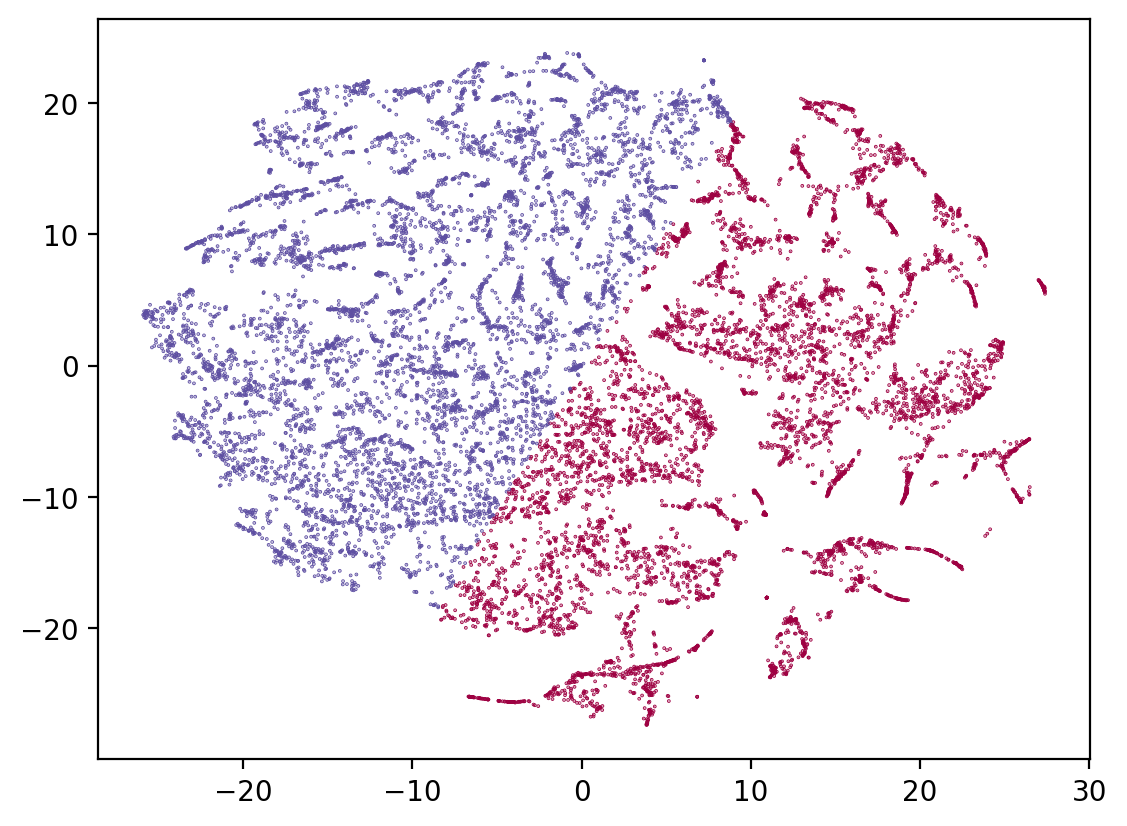

In [109]:
plt.scatter(tsne[:, 0], tsne[:, 1], c=kmeans_tsne_labels, s=0.1, cmap='Spectral')

In [79]:
from bokeh.layouts import column
name = result.error_label.tolist()
source1 = ColumnDataSource(dict(
    x=adata.obsm['X_umap'][:,0],
    y=adata.obsm['X_umap'][:,1],
    color=result.error_color,
    label=name
))
p1 = figure(plot_width=450, plot_height=400, title="UMAP")
p1.circle(x='x', y='y', color='color', fill_alpha=0.8, size=2,legend_field='label', source=source1)

source2 = ColumnDataSource(dict(
    x=XEn[:,0],
    y=XEn[:,1],
    color=result.error_color,
    label=name
))
p2 = figure(plot_width=450, plot_height=400, title="Autoencoder")
p2.circle(x='x', y='y', color='color', fill_alpha=0.8, size=2,legend_field='label', source=source2)

source3 = ColumnDataSource(dict(
    x=tsne[:,0],
    y=tsne[:,1],
    color=result.error_color,
    label=name
))
p3 = figure(plot_width=450, plot_height=400, title="t-SNE")
p3.circle(x='x', y='y', color='color', fill_alpha=0.8, size=2,legend_field='label', source=source3)



grid = gridplot([[p1, p2], [p3, None]])

show(grid)